## Analysis on the Effectiveness of Northwind's Discount Program
#### Hypothesis Testing   //   V2/Mod3 Final   //   Joe Nelson

### We were asked to provide insight on the following questions regarding Northwind's Discount Program:

**_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

**_Do orders that include discounts generate more revenue than those without?_**

**_Do customers who order discounted items have a statistically significant higher re-order rate than customers who do not order discounted items?_** 

**_Does the region of Northwind customers have a statistically significant effect on quantities ordered?_**

Alpha used across all hypotheses is .05. 

In [1]:
# Import necessary libraries 
import sqlite3 
import pandas as pd
import numpy as np
import scipy.stats as stats 
from statistics import mean, stdev
from math import sqrt
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

conn = sqlite3.connect('Northwind_small.sqlite')   
cur = conn.cursor() 

## Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [2]:
# Select relevant data
cur.execute("""
    SELECT Quantity, Discount
    FROM OrderDetail; 
    """)

df = pd.DataFrame(cur.fetchall()) 
df.columns = [x[0] for x in cur.description] 
df.head(5)

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [3]:
#Continue reviewing the data
df.describe()
df.groupby('Discount').count()

,Quantity
Discount,
0.00,1317
0.01,1
0.02,2
0.03,3
0.04,1
0.05,185
0.06,1
0.10,173
0.15,157


#### Observed:
Discounts range from 1% to 25%, with a mean of 14.4%.  
Discounts are applied with 10 unique values: 1%, 2%, 3%, 4%, 5%, 6%, 10%, 15%, 20%, and 25%; the non-multiples of 5% have too few observations to be included; we'll re-create the dataframe with only multiples of 5%.

In [4]:
cur.execute("""
    SELECT Quantity, Discount
    FROM OrderDetail
    WHERE (Discount = 0) or (Discount = .05) or (Discount = 0.1) or (Discount = 0.15) or (Discount = 0.2) 
    or (Discount = 0.25); 
    """)

df = pd.DataFrame(cur.fetchall()) 
df.columns = [x[0] for x in cur.description] 
df.groupby('Discount').count()

,Quantity
Discount,
0.00,1317
0.05,185
0.10,173
0.15,157
0.20,161
0.25,154


## Question 1.1: Does Discount have a statistically significant affect on the quantity of a product in an order?

Ho: Discounts do not have a statistically significant effect on quantity ordered.
<br>Ha: Discounts have a statistically significant effect on the quantity ordered.

In [5]:
df_nodisc = df.loc[df ['Discount'] == 0.0,['Quantity']] 
df_yesdisc = df.loc[df['Discount'] > 0.0, ['Quantity']]

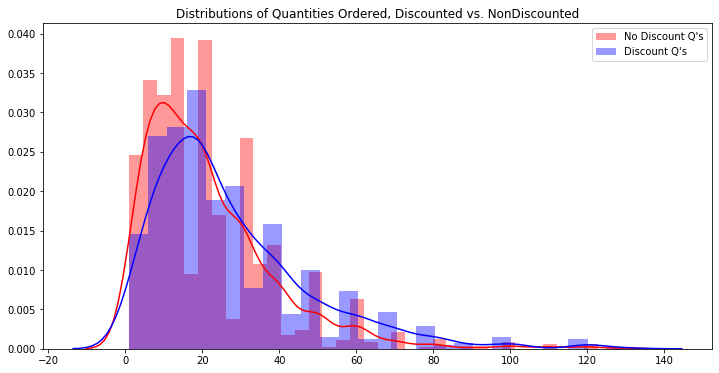

In [6]:
#Review distributions of each sample:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df_nodisc, color='r', label="No Discount Q's", ax=ax) 
sns.distplot(df_yesdisc, color = 'b', label = "Discount Q's")
plt.title('Distributions of Quantities Ordered, Discounted vs. NonDiscounted')
plt.legend() 
plt.show() 

In [7]:
nodisc_var = np.var(df_nodisc)
yesdisc_var = np.var(df_yesdisc)
print('Variance of Nondiscounted Sample: ',round(nodisc_var,2),
      '\nVariance of Discounted Sample: ',round(yesdisc_var,2))

Variance of Nondiscounted Sample:  Quantity    306.28
dtype: float64 
Variance of Discounted Sample:  Quantity    428.83
dtype: float64


__Observed:__ The samples are skewed to the right and variances are not similar (they're more than 33% apart). Because the sample sizes are large (838 and 1317), Welch's T-test would the appropriate test.  

In [8]:
#Welch's T-Test Function; determine T-statistic and Degrees of Freedom

def welch_t(a, b):   #FIRST GET T-STATISTIC 
    numerator = np.mean(a) - np.mean(b) 
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)    
    return abs(numerator/denominator) 
def welch_df(a, b):  #THEN GET EFFECTIVE DEGREES OF FREEDOM 
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1) 
    n1 = a.size 
    n2 = b.size 
    numerator = (s1/n1 + s2/n2)**2 
    denominator = (s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1) 
    return abs(numerator/denominator) 
def p_value(a, b, two_sided=False): 
    t = welch_t(a,b) 
    df = welch_df(a,b) 
    p = 1 - stats.t.cdf(t, df) 
    if two_sided == True: 
        return p*2 
    else: 
        return p 

In [9]:
print('P-value is: ',p_value(df_nodisc, df_yesdisc))

P-value is:  [5.02562436e-11]


__Conclusion:__ Because the p-value is below .05, we can reject the null hypothesis that there's no difference between the sample means. <br>The question now becomes at what level of discount is there a statistically significant effect on quantity ordered. 

## Question 1.2: Which levels of discount have a statistically significant affect on the quantity of a product in an order?

Ho: Discount level (i) does not have a statistically significant effect on quantity ordered.
<br>Ha: Discount level (i) has a statistically significant effect on the quantity ordered.

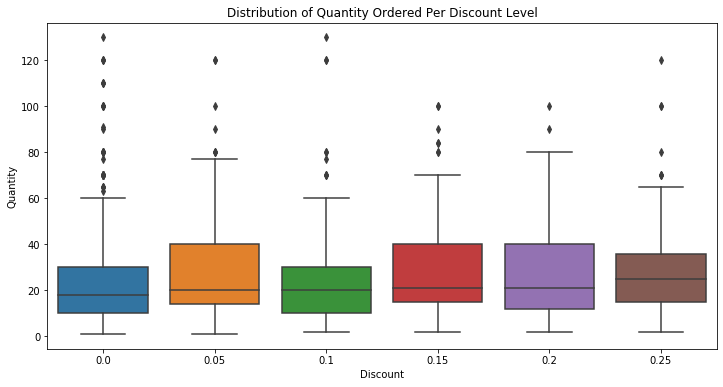

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(df.Discount, df.Quantity, ax=ax).set_title("Distribution of Quantity Ordered Per Discount Level")
plt.show()

In [11]:
formula = 'df.Quantity ~ df.Discount'
lm = ols(formula, df).fit() 
table = sm.stats.anova_lm(lm, typ=2) 
print(table) 

                    sum_sq      df          F        PR(>F)
df.Discount   12621.238965     1.0  35.487951  2.991487e-09
Residual     762866.181622  2145.0        NaN           NaN


__Observed:__ The ANOVA test shows a P value < 0.05, allowing us to reject the null hypothesis (that there's no statistically significant difference between the various samples).  The Tukey HSD test (below) will show *which* samples have a statistically significant difference from the no-discount sample set. 

In [12]:
MultiComp = MultiComparison(df.Quantity,
                            df.Discount)

In [13]:
results = MultiComp.tukeyhsd()
print(results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05   6.2955  0.001  2.0814 10.5097   True
   0.0    0.1   3.5217 0.1885 -0.8187  7.8622  False
   0.0   0.15   6.6669  0.001  2.1352 11.1986   True
   0.0    0.2   5.3096 0.0096  0.8285  9.7907   True
   0.0   0.25    6.525  0.001   1.954  11.096   True
  0.05    0.1  -2.7738  0.704 -8.4504  2.9028  False
  0.05   0.15   0.3714    0.9 -5.4528  6.1955  False
  0.05    0.2   -0.986    0.9 -6.7708  4.7989  False
  0.05   0.25   0.2294    0.9 -5.6253  6.0842  False
   0.1   0.15   3.1452 0.6333  -2.771  9.0613  False
   0.1    0.2   1.7879    0.9 -4.0896  7.6653  False
   0.1   0.25   3.0033  0.677  -2.943  8.9496  False
  0.15    0.2  -1.3573    0.9 -7.3775  4.6628  False
  0.15   0.25  -0.1419    0.9 -6.2292  5.9454  False
   0.2   0.25   1.2154    0.9 -4.8343  7.2652  False
----------------------------------------------

__Conclusion:__ Using the Tukey HSD test, we can reject the null hypotheses as to the 5, 15, 20, and 25% discount levels, and conclude that **Discounts offer a statisticaly significant effect on quantity at the 5, 15, 20, and 25% levels.**  The 10% discount level has a similar sample size as the first noted set, and was therefore likely rejected to the P-value exceeding the alpha of 0.05.  

## Question 1.3: _**How**_ different are quantities ordered of the discounted items from the non-discounted items?

We will only review the effect size for the statistically significant discount levels above.

In [14]:
def cohens_d (c0,c1):
    return (abs(mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2)))

In [15]:
# Define the Cohen's d function
#def Cohen_d(group1, group2):  
#    diff = group1.mean() - group2.mean() 
#    n1, n2 = len(group1), len(group2) 
#    var1 = group1.var() 
#    var2 = group2.var() 
#    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2) 
#    d = diff / np.sqrt(pooled_var) 
#    return d 

In [16]:
#Define interpretation of effect size
def interpret_cohensd(cohens_d):
    if 0<=cohens_d<0.1:
        significance = "very small"
    elif 0.1<=cohens_d<0.35:
        return("small")
    elif 0.35<=cohens_d<0.65:
        return("medium")
    elif 0.65<=cohens_d<0.9:
        return("large")
    elif cohens_d >= 0.9:
        return("very large")

In [17]:
sig_discount_levels = [0.05,0.15,0.2,0.25]

In [18]:
c0 = df.loc[df['Discount'] == 0.0,['Quantity']] 
c0 = c0.Quantity.tolist()

for level in sig_discount_levels:
    c1 = df.loc[df['Discount'] == level, ['Quantity']] 
    c1 = c1.Quantity.tolist()
    d = cohens_d (c0, c1)
    significance = interpret_cohensd(d)
    print('\nAt discount level',level*100,'%, there is a relatively',significance,
          'effect on quantity ordered. Cohen\'s d of', round(d,2))
    


At discount level 5.0 %, there is a relatively small effect on quantity ordered. Cohen's d of 0.32

At discount level 15.0 %, there is a relatively small effect on quantity ordered. Cohen's d of 0.35

At discount level 20.0 %, there is a relatively small effect on quantity ordered. Cohen's d of 0.29

At discount level 25.0 %, there is a relatively small effect on quantity ordered. Cohen's d of 0.35


**Conclusion:** Overall, all levels of discounts had the relatively same effect on quantities ordered. 

## Question 2: Do orders that include discounts generate more revenue than those without?

This question will examine whether orders with discounts generate more revenue than those without, on the general assumption that people will buy more of a product when it's cheaper.  

Ho = There is no significant difference in revenue between orders with discounted products than those without.
<br>Ha = There is a significant difference in revenue between discounted and non-discounted orders.

In [19]:
# Select relevant data
cur.execute("""
    SELECT  *
    FROM OrderDetail;
    """)

df = pd.DataFrame(cur.fetchall()) 
df.columns = [x[0] for x in cur.description] 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [20]:
# Calculte revenue per item ordered and then only including relevant columns
df['Revenue'] = df.UnitPrice * df.Quantity * (1-df.Discount)
df_revenue = df[['OrderId', 'Revenue', 'Discount']]

In [21]:
# Narrow the dataframe further by grouping revenue per order
df_grouped = df_revenue.groupby(['OrderId']).sum()
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 10248 to 11077
Data columns (total 2 columns):
Revenue     830 non-null float64
Discount    830 non-null float64
dtypes: float64(2)
memory usage: 19.5 KB


In [26]:
# Split the groups into discounted and nondiscounted samples

df_rev_w_disc = df_grouped.loc[df_grouped['Discount'] > 0, ['Revenue']]
df_rev_wo_disc = df_grouped.loc[df_grouped['Discount'] == 0, ['Revenue']]
df_rev_w_disc.info()
df_rev_wo_disc.info()
print('\n', 'Variance - with discount:',df_rev_w_disc.var().tolist(), '\n Variance - no discount:',
      df_rev_wo_disc.var().tolist())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 10250 to 11077
Data columns (total 1 columns):
Revenue    380 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 10248 to 11073
Data columns (total 1 columns):
Revenue    450 non-null float64
dtypes: float64(1)
memory usage: 7.0 KB

 Variance - with discount: [3581360.050587769] 
 Variance - no discount: [3214064.5144391293]


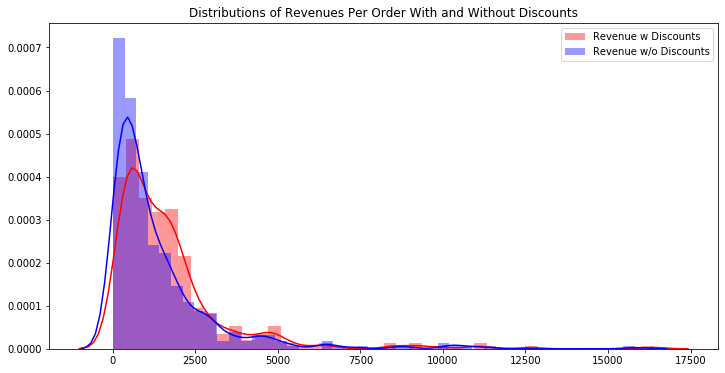

In [27]:
#Review distributions of each sample:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df_rev_w_disc, color='r', label="Revenue w Discounts", ax=ax) 
sns.distplot(df_rev_wo_disc, color = 'b', label = "Revenue w/o Discounts")
plt.title('Distributions of Revenues Per Order With and Without Discounts')
plt.legend() 
plt.show() 

The two samples have 380 and 450 observations, respectively, with somewhat similar variances of 3.58e+06 and 3.21e+06.  The distributions are strongly skewed to the right, but the sample sizes are large enough that a  Welch's T-test would be an appropriate hypothesis test for these samples.  

In [28]:
# Calculate means and perform two-sided T-test 

mean_w_disc = (df_rev_w_disc.mean()).tolist()
mean_wo_disc = (df_rev_wo_disc.mean()).tolist()
disc_p_val = (p_value(df_rev_w_disc, df_rev_wo_disc,True)).tolist()

In [30]:
print('Average Revenue Per Order WITH Discounts is ${} and without discounts is ${}. \nThis difference is \
statistically significant because the P-value is {}, which is below the alpha, \nallowing us to REJECT \
the null hypothesis (there is a significant relationship between discounts and quantity ordered.'
      .format(round(mean_w_disc[0],2), round(mean_wo_disc[0],2), round(disc_p_val[0],5)))

Average Revenue Per Order WITH Discounts is $1702.35 and without discounts is $1375.33. 
This difference is statistically significant because the P-value is 0.01125, which is below the alpha, 
allowing us to REJECT the null hypothesis (there is a significant relationship between discounts and quantity ordered.


## Question 3: Do customers who order discounted items have a statistically significant higher re-order rate than customers who do not order discounted items?

This question will examine whether customers with applied discounts order more than customers who do not have discounts applied.  

Ho = There is no significant difference in the number of orders from customers who have discounts applied.
<br>Ha = There is a significant difference in the number of orders from customers who have discounts applied.

In [31]:
# Select relevant data
cur.execute("""
    SELECT o.CustomerId, od.Discount
    FROM "Order" o
    JOIN OrderDetail od
    ON o.Id = od.OrderId
    GROUP BY (OrderID)
    ORDER BY (CustomerId)
    ;
    """)

df = pd.DataFrame(cur.fetchall()) 
df.columns = [x[0] for x in cur.description] 
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
CustomerId    830 non-null object
Discount      830 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB


,CustomerId,Discount
0,ALFKI,0.25
1,ALFKI,0.00
2,ALFKI,0.00
3,ALFKI,0.00
4,ALFKI,0.05


In [32]:
# Count number of orders for each customer ID
df['N_Orders'] = df['CustomerId'].map(df['CustomerId'].value_counts())
df.head()

,CustomerId,Discount,N_Orders
0,ALFKI,0.25,6
1,ALFKI,0.00,6
2,ALFKI,0.00,6
3,ALFKI,0.00,6
4,ALFKI,0.05,6


In [33]:
# Consolidate multiple rows of each order ID, showing which received discounts
df2 = df.groupby(['CustomerId','N_Orders'], as_index=False)['Discount'].sum()
df2.head()

,CustomerId,N_Orders,Discount
0,ALFKI,6,0.35
1,ANATR,4,0.00
2,ANTO,7,0.40
3,AROUT,13,0.40
4,BERGS,18,0.90


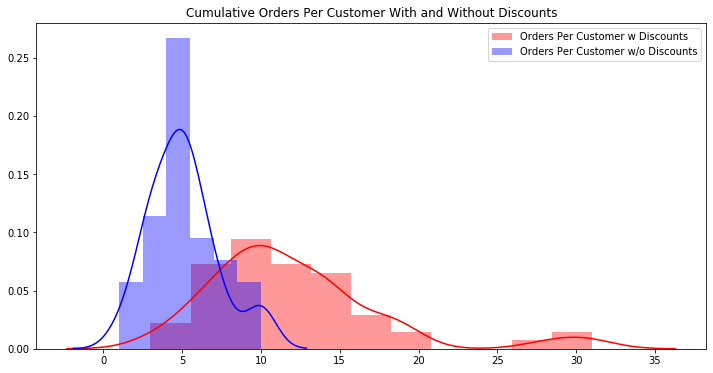

In [34]:
# Divide the sample into discounts and no-discounts, then review histograms

df2_nodiscounts = df2.loc[df2['Discount'] == 0.0, ['N_Orders']] 
df2_discounts = df2.loc[df2['Discount'] > 0.0, ['N_Orders']] 

#Review distributions of each sample:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(df2_discounts, color='r', label="Orders Per Customer w Discounts", ax=ax) 
sns.distplot(df2_nodiscounts, color = 'b', label = "Orders Per Customer w/o Discounts")
plt.title('Cumulative Orders Per Customer With and Without Discounts')
plt.legend() 
plt.show() 

In [35]:
print('\n','Orders with Discounts, Variance:',df2_discounts.var().tolist(), 'N Observations:',len(df2_discounts),
      '\n Variance, Orders with No Discounts:',df2_nodiscounts.var().tolist(), 'N Observations:',len(df2_nodiscounts))


 Orders with Discounts, Variance: [33.14220824598183] N Observations: 54 
 Variance, Orders with No Discounts: [4.82016806722689] N Observations: 35


Considering the differing variances and number of observations, Welch's T-Test would be appropriate to test this hypothesis. 

In [36]:
# Calculate means and perform two-sided T-test 

mean_w_disc = (df2_discounts.N_Orders.mean()).tolist()
mean_wo_disc = (df2_nodiscounts.N_Orders.mean()).tolist()
disc_p_val = (p_value(df2_discounts.N_Orders, df2_nodiscounts.N_Orders,True)).tolist()
round(mean_w_disc,2)

12.09

In [37]:
print('The Average number of orders for customers who have discounts applied is {} orders. \
    \nThe average numer of rders for customers who do NOT have discounts applied is {} orders. \
    \nThis difference is statistically significant because the P-value is {}, which is below the alpha, \
    \nallowing us to REJECT the null hypothesis and conclude that there is a significant relationship \
    \nbetween discounts applied and the number of orders per customer.'
      .format(round(mean_w_disc,2), round(mean_wo_disc,2), round(disc_p_val,20)))

The Average number of orders for customers who have discounts applied is 12.09 orders.     
The average numer of rders for customers who do NOT have discounts applied is 5.06 orders.     
This difference is statistically significant because the P-value is 8.04334377e-12, which is below the alpha,     
allowing us to REJECT the null hypothesis and conclude that there is a significant relationship     
between discounts applied and the number of orders per customer.


It should be noted that this result is merely corralative; it does not imply that discounts cause additional orders.  Additional work would be needed to determine this.

## Question 4: 